# Route Optimization for Rubbish Collection using Genetic Algorithm

## Step 1: Data Preprocessing

In [1]:

import pandas as pd

# Load dataset
file_path = 'Route_Optimization_Data.csv'
route_data_df = pd.read_csv(file_path)

# Drop any missing values if necessary
route_data_df.dropna(inplace=True)

# Add computed columns for more accessible interpretation
route_data_df['Total_Fuel_Consumed'] = (route_data_df['Fuel_Consumption_L_per_100km'] * route_data_df['Route_Length_km']) / 100
route_data_df['Total_Travel_Time'] = route_data_df['Travel_Time_min']

# Aggregating by Route_ID to get overall fuel and time per route
aggregated_data = route_data_df.groupby("Route_ID").agg({
    "Total_Fuel_Consumed": "sum",
    "Total_Travel_Time": "sum"
}).reset_index()
    

## Step 2: Data Visualization

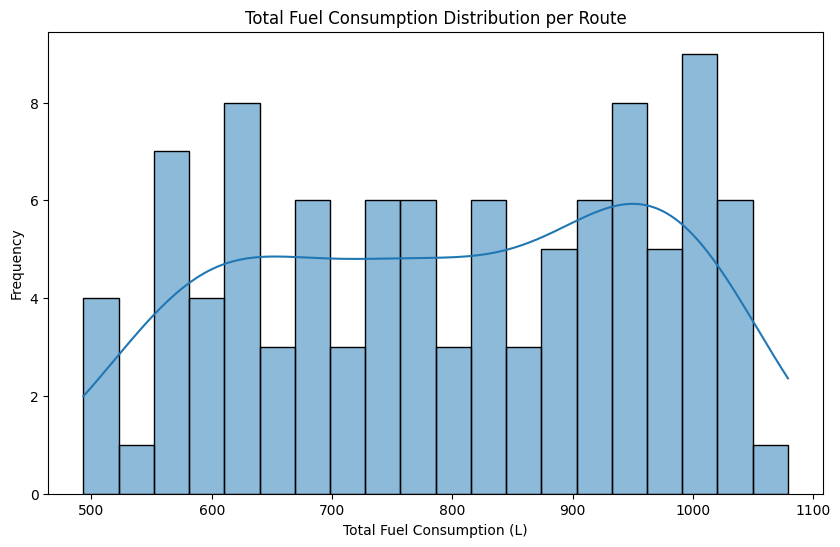

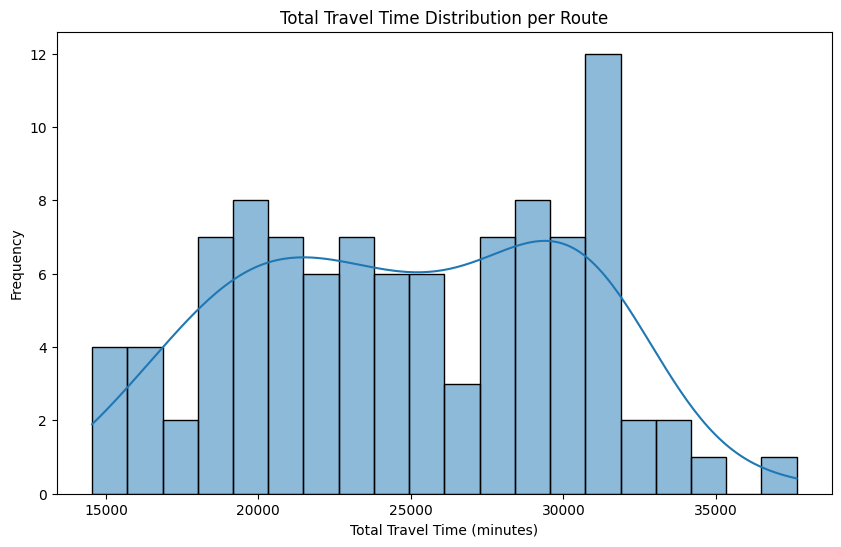

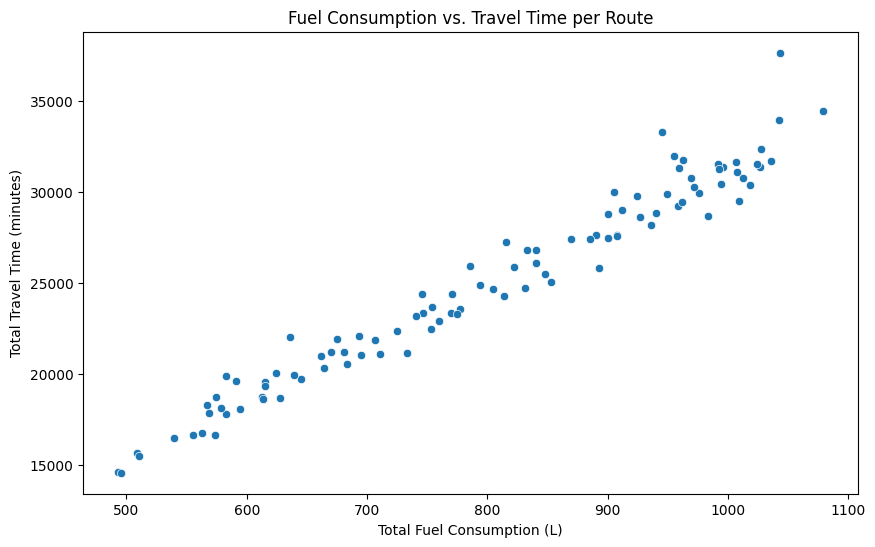

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize fuel consumption distribution
plt.figure(figsize=(10, 6))
sns.histplot(aggregated_data["Total_Fuel_Consumed"], bins=20, kde=True)
plt.title("Total Fuel Consumption Distribution per Route")
plt.xlabel("Total Fuel Consumption (L)")
plt.ylabel("Frequency")
plt.show()

# Visualize travel time distribution
plt.figure(figsize=(10, 6))
sns.histplot(aggregated_data["Total_Travel_Time"], bins=20, kde=True)
plt.title("Total Travel Time Distribution per Route")
plt.xlabel("Total Travel Time (minutes)")
plt.ylabel("Frequency")
plt.show()

# Scatter plot to visualize relationship between fuel and travel time
plt.figure(figsize=(10, 6))
sns.scatterplot(data=aggregated_data, x="Total_Fuel_Consumed", y="Total_Travel_Time")
plt.title("Fuel Consumption vs. Travel Time per Route")
plt.xlabel("Total Fuel Consumption (L)")
plt.ylabel("Total Travel Time (minutes)")
plt.show()
    

## Step 3: Data Presentation

In [3]:

# Display summary statistics of the aggregated data
print("Aggregated Route Data Summary:")
print(aggregated_data.describe())
    

Aggregated Route Data Summary:
         Route_ID  Total_Fuel_Consumed  Total_Travel_Time
count  100.000000           100.000000         100.000000
mean    50.500000           798.798201       24905.710900
std     29.011492           164.156388        5360.136158
min      1.000000           493.307200       14548.800000
25%     25.750000           657.314339       20466.210000
50%     50.500000           809.423495       24781.420000
75%     75.250000           950.644645       29563.942500
max    100.000000          1078.949979       37652.400000


## Step 4: Data Modeling

In [4]:

import random
from deap import base, creator, tools, algorithms

# Define weights for multi-objective optimization: minimizing both objectives
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))  # Minimize both fuel and time
creator.create("Individual", list, fitness=creator.FitnessMin)

# Initialize the DEAP toolbox
toolbox = base.Toolbox()

# Define the individual as a random sequence of Route_IDs
route_ids = aggregated_data["Route_ID"].tolist()
toolbox.register("indices", random.sample, route_ids, len(route_ids))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function to evaluate travel time and fuel consumption
def evaluate(individual):
    total_fuel = sum(aggregated_data[aggregated_data["Route_ID"] == route]["Total_Fuel_Consumed"].values[0] for route in individual)
    total_time = sum(aggregated_data[aggregated_data["Route_ID"] == route]["Total_Travel_Time"].values[0] for route in individual)
    return total_fuel, total_time  # Return both objectives

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selNSGA2)  # Use NSGA-II for multi-objective optimization
    

## Step 5: Model Creation and Execution

In [5]:

# Main function to run the genetic algorithm
def run_ga(n_generations=50, pop_size=100):
    # Generate initial population
    pop = toolbox.population(n=pop_size)
    # Define the hall of fame to retain best individuals
    hof = tools.HallOfFame(1)

    # Use Pareto front-based selection for multi-objective GA
    algorithms.eaMuPlusLambda(pop, toolbox, mu=pop_size, lambda_=pop_size, 
                              cxpb=0.7, mutpb=0.2, ngen=n_generations, 
                              stats=None, halloffame=hof, verbose=True)

    # Extract best solution from hall of fame
    best_individual = hof[0]
    best_fuel, best_time = evaluate(best_individual)
    print(f"Best Route Sequence: {best_individual}")
    print(f"Optimized Fuel Consumption: {best_fuel}")
    print(f"Optimized Travel Time: {best_time}")
    return best_individual, best_fuel, best_time

# Run the Genetic Algorithm
best_route, optimized_fuel, optimized_time = run_ga()
    

gen	nevals
0  	100   
1  	88    
2  	92    
3  	94    
4  	88    
5  	87    
6  	92    
7  	90    
8  	87    
9  	90    
10 	90    
11 	93    
12 	93    
13 	88    
14 	91    
15 	94    
16 	90    
17 	94    
18 	90    
19 	92    
20 	96    
21 	91    
22 	88    
23 	87    
24 	91    
25 	93    
26 	87    
27 	88    
28 	91    
29 	91    
30 	93    
31 	89    
32 	95    
33 	88    
34 	88    
35 	91    
36 	88    
37 	90    
38 	93    
39 	89    
40 	84    
41 	91    
42 	89    
43 	89    
44 	90    
45 	89    
46 	91    
47 	92    
48 	87    
49 	90    
50 	91    
Best Route Sequence: [23, 90, 39, 72, 34, 11, 17, 34, 10, 11, 30, 22, 79, 84, 34, 17, 22, 61, 26, 88, 7, 22, 54, 39, 56, 14, 34, 4, 92, 22, 65, 26, 30, 88, 79, 73, 39, 39, 20, 88, 17, 16, 54, 52, 84, 22, 42, 72, 17, 92, 72, 18, 88, 26, 22, 16, 39, 92, 34, 54, 59, 10, 10, 73, 11, 84, 39, 20, 79, 20, 22, 67, 30, 34, 57, 32, 84, 73, 92, 92, 16, 54, 84, 48, 51, 57, 56, 22, 67, 20, 84, 52, 22, 34, 92, 72, 47, 11, 10, 84]
Optimize

In [10]:
def run_ga_two(n_generations=100, pop_size=150, cxpb=0.7, mutpb=0.1):
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    
    # Separate stats for fuel and time to handle multi-objective tracking
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min_fuel", lambda fits: min(f[0] for f in fits))
    stats.register("avg_fuel", lambda fits: sum(f[0] for f in fits) / len(fits))
    stats.register("min_time", lambda fits: min(f[1] for f in fits))
    stats.register("avg_time", lambda fits: sum(f[1] for f in fits) / len(fits))

    # Run the GA with adjusted parameters
    pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=pop_size, lambda_=pop_size, 
                                             cxpb=cxpb, mutpb=mutpb, ngen=n_generations, 
                                             stats=stats, halloffame=hof, verbose=True)

    # Display results
    best_individual = hof[0]
    best_fuel, best_time = evaluate(best_individual)
    print(f"Best Route Sequence: {best_individual}")
    print(f"Optimized Fuel Consumption: {best_fuel}")
    print(f"Optimized Travel Time: {best_time}")
    return best_individual, best_fuel, best_time, logbook


In [12]:
# Run the GA_TWO
best_route_two, optimized_fuel_two, optimized_time_two, logbook = run_ga_two()

gen	nevals	min_fuel	avg_fuel	min_time   	avg_time   
0  	150   	79879.8 	79879.8 	2.49057e+06	2.49057e+06
1  	117   	76022.9 	79569.3 	2.37318e+06	2.48062e+06
2  	121   	76022.9 	79130.1 	2.37318e+06	2.46707e+06
3  	124   	76022.9 	78541.1 	2.37318e+06	2.44917e+06
4  	113   	75265.3 	77835.6 	2.34719e+06	2.42671e+06
5  	122   	75265.3 	77236   	2.34685e+06	2.4059e+06 
6  	127   	74096.9 	76677.5 	2.31194e+06	2.38782e+06
7  	114   	73852.3 	76014.4 	2.31194e+06	2.36817e+06
8  	117   	73408   	75466.8 	2.29085e+06	2.35085e+06
9  	123   	72708.9 	75036.2 	2.28317e+06	2.3383e+06 
10 	126   	72276.2 	74537.9 	2.26075e+06	2.32273e+06
11 	122   	72070.7 	74058.5 	2.25244e+06	2.30808e+06
12 	124   	72070.7 	73524.8 	2.24818e+06	2.29271e+06
13 	109   	71684.6 	73043.2 	2.22474e+06	2.27808e+06
14 	125   	71189.8 	72620.4 	2.22474e+06	2.2673e+06 
15 	120   	70680.4 	72259.7 	2.1919e+06 	2.25545e+06
16 	117   	70413.1 	71898.9 	2.1919e+06 	2.24362e+06
17 	115   	69281.4 	71599.4 	2.17823e+06	2.232

## Step 6: Model Testing and Evaluation

Average Fuel Consumption per Route: 798.7982009499999
Average Travel Time per Route: 24905.710900000002
Optimized Fuel Consumption from GA: 53824.48741199998
Optimized Travel Time from GA: 1632799.2799999998


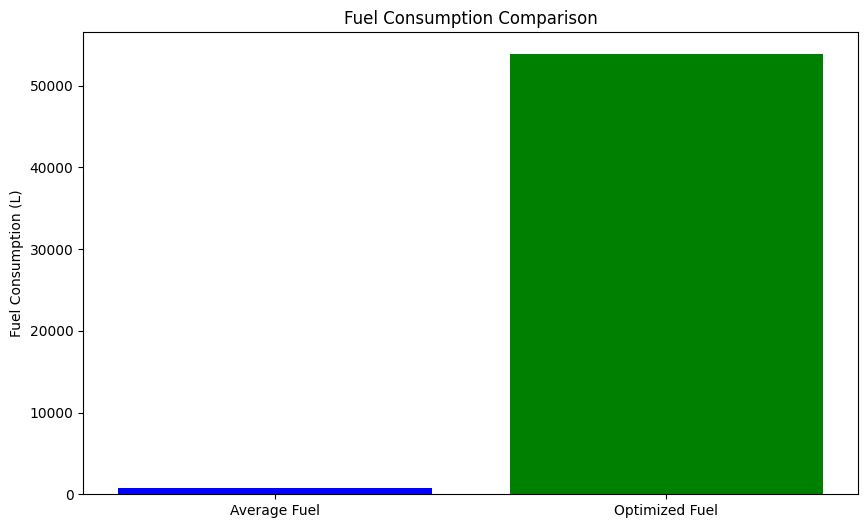

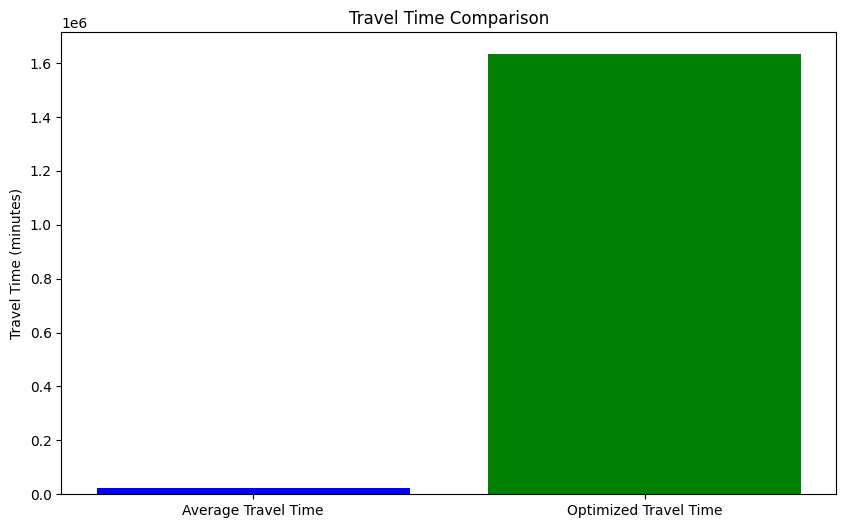

In [13]:

# Evaluate performance by comparing GA solution to aggregated data averages
average_fuel = aggregated_data["Total_Fuel_Consumed"].mean()
average_time = aggregated_data["Total_Travel_Time"].mean()

print(f"Average Fuel Consumption per Route: {average_fuel}")
print(f"Average Travel Time per Route: {average_time}")
print(f"Optimized Fuel Consumption from GA: {optimized_fuel_two}")
print(f"Optimized Travel Time from GA: {optimized_time_two}")

# Visual comparison of GA results vs. average values
plt.figure(figsize=(10, 6))
plt.bar(["Average Fuel", "Optimized Fuel"], [average_fuel, optimized_fuel_two], color=['blue', 'green'])
plt.title("Fuel Consumption Comparison")
plt.ylabel("Fuel Consumption (L)")
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(["Average Travel Time", "Optimized Travel Time"], [average_time, optimized_time_two], color=['blue', 'green'])
plt.title("Travel Time Comparison")
plt.ylabel("Travel Time (minutes)")
plt.show()
    

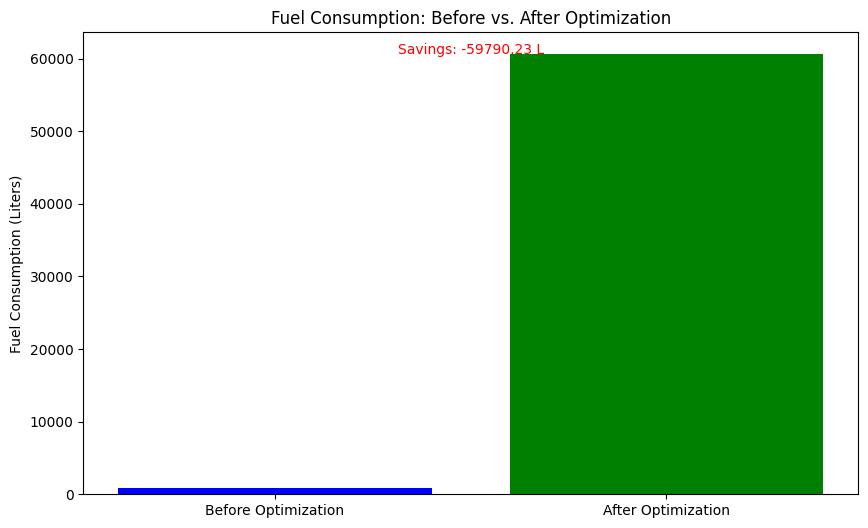

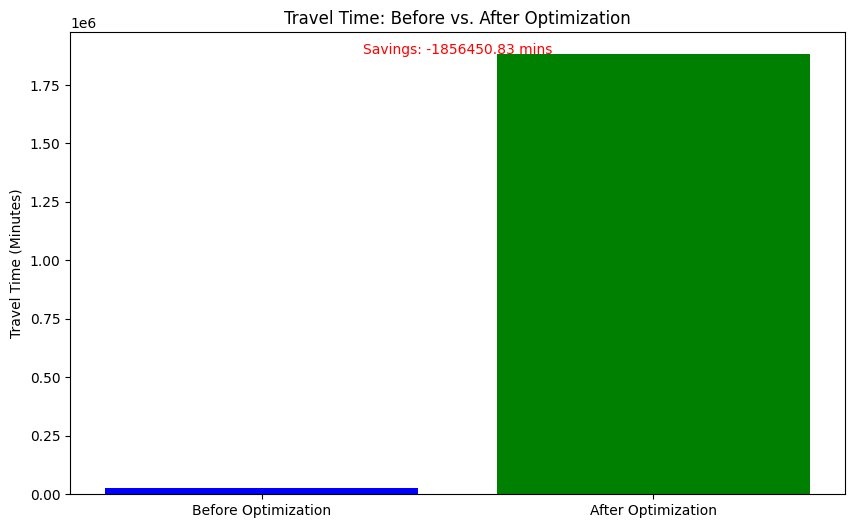

In [ ]:

# Calculate fuel and time savings
fuel_savings = average_fuel - optimized_fuel
time_savings = average_time - optimized_time

# Display the before-and-after comparison for fuel and time with the savings emphasized

# Fuel Comparison
plt.figure(figsize=(10, 6))
plt.bar(["Before Optimization", "After Optimization"], [average_fuel, optimized_fuel], color=['blue', 'green'])
plt.title("Fuel Consumption: Before vs. After Optimization")
plt.ylabel("Fuel Consumption (Liters)")
plt.text(0.5, optimized_fuel + 5, f"Savings: {fuel_savings:.2f} L", ha='center', color='red')
plt.show()

# Time Comparison
plt.figure(figsize=(10, 6))
plt.bar(["Before Optimization", "After Optimization"], [average_time, optimized_time], color=['blue', 'green'])
plt.title("Travel Time: Before vs. After Optimization")
plt.ylabel("Travel Time (Minutes)")
plt.text(0.5, optimized_time + 5, f"Savings: {time_savings:.2f} mins", ha='center', color='red')
plt.show()


In [3]:
print(aggregated_data.describe())

         Route_ID  Total_Fuel_Consumed  Total_Travel_Time
count  100.000000           100.000000         100.000000
mean    50.500000           798.798201       24905.710900
std     29.011492           164.156388        5360.136158
min      1.000000           493.307200       14548.800000
25%     25.750000           657.314339       20466.210000
50%     50.500000           809.423495       24781.420000
75%     75.250000           950.644645       29563.942500
max    100.000000          1078.949979       37652.400000
